In [206]:
import numpy as np
from typing import Callable
from numpy.typing import NDArray, ArrayLike
import csv
from datetime import datetime, timezone
import astropy
import pytz
from astropy.time import Time
import math
from pyquaternion import Quaternion
import pymap3d
import matplotlib.pyplot as plt
import ppigrf
import pyorb.kepler as kepler
import pyorb.orbit as orbit
from GravityModels.CelestialBodies.Planets import Earth
from GravityModels.Models import SphericalHarmonics

In [440]:
def estimate_jacobian(f : Callable[NDArray[np.float64], NDArray[np.float64]],
                     state : NDArray[np.float64], #1 dimensional vector
                      epsilon = 0.000001 #limit definition of the derivative applied to vectorvalued partials
                     ):
    y = f(state)
    n = state.shape[0]#function input vector shape
    m = y.shape[0]#function output vector shape
    J = np.zeros((m, n))
    for i in range(n):
        state_1 = np.copy(state)
        state_1[i] = state[i] + epsilon
        f_1 = f(state_1)
        for j in range(m):
            J[j][i] = (f_1[j] - y[j])/epsilon

    return J

def raw_igdf_enu(height_from_sea_level : np.float64, lat : np.float64, lon : np.float64, time):
    #kilometers, degrees, degrees
    #returns B_east, b_north, b_up in nT: https://github.com/IAGA-VMOD/ppigrf/tree/main
    return ppigrf.igrf(lon, lat, height_from_sea_level, time)

def igdf_eci_vector(x : np.float64, y : np.float64, z : np.float64, time):
    #eci in METERS, returns unit eci igdf vector
    lat, lon, alt = pymap3d.eci2geodetic(x, y, z, time)
    b_east, b_north, b_up = raw_igdf_enu(alt/1000, lat, lon, time)
    ecefb_x, ecefb_y, ecefb_z = pymap3d.enu2ecef(b_east, b_north, b_up, lat, lon, alt)
    b_x, b_y, b_z = pymap3d.ecef2eci(ecefb_x, ecefb_y, ecefb_z, time)
    b_vec = np.array([b_x - x, b_y - y, b_z - z])
    return b_vec

In [441]:
earth = Earth()
earth_sph_harm = SphericalHarmonics(earth.sh_file, 4)

In [442]:
air_density = 10e-15
body_length = 3
body_mass = 1
mu_of_earth = 3.986e14
time = datetime.now()
dt = 30
def f(state):
    orb = orbit.Orbit(M0 = 5.972e24, kepler = state.reshape((6,1)))
    orb.propagate(dt)
    return orb.kepler[:, 0]
    
def h(state):
    eci_measurements = kepler.kep_to_cart(kep = state, mu = mu_of_earth)
    magnetic_vec = igdf_eci_vector(eci_measurements[0], eci_measurements[1], eci_measurements[2], time)
    return np.array([np.linalg.norm(magnetic_vec)])

In [443]:
Q = np.eye(6) * 0.001
R = 100

def EKF_iter(previous_state, previous_covariance, received_measurements):
    state_estimate = f(previous_state)
    F = estimate_jacobian(f, previous_state)
    covariance_estimate = F@previous_covariance@F.T + Q
    residual = received_measurements - h(state_estimate)
    H = estimate_jacobian(h, state_estimate)
    S = H@covariance_estimate@H.T + R
    K = covariance_estimate@H.T@np.linalg.inv(S)

    predicted_state = state_estimate + K@residual
    predicted_covariance = (np.eye(6) - K@H)@covariance_estimate
    
    return predicted_state, predicted_covariance

In [455]:
position = np.array([7e6, math.radians(0.05), math.radians(50), math.radians(311.6218), math.radians(199.2431), math.radians(48.4420)])
cov = np.eye(6)*100000
orb = orbit.Orbit(M0 = 5.972e24, kepler = position.reshape((6,1)))
posns = []
realposns = []
for i in range(int(90*60.0/dt)):
    orb.propagate(dt)
    current_posn = orb.cartesian[:,0]
    realposns.append(current_posn)

    estimated_posn = kepler.kep_to_cart(kep = position, mu = mu_of_earth)[:3]
    posns.append(estimated_posn)
    
    magnetic_vec = igdf_eci_vector(current_posn[0], current_posn[1], current_posn[2], time)
    position, covariance = EKF_iter(position, cov, [np.linalg.norm(magnetic_vec) + np.random.normal(scale = 10)])
    
    #print(np.linalg.norm(position-orb.kepler[:,0]))

print(np.linalg.norm(kepler.kep_to_cart(kep = position, mu = mu_of_earth)[:3] - orb.cartesian[:,0][:3])/1000)



7.783278406337612


In [452]:
realposns = np.array(realposns)
posns = np.array(posns)

xreal = realposns[:,0]
yreal = realposns[:,1]
zreal = realposns[:,2]
x = posns[:,0]
y = posns[:,1]
z = posns[:,2]

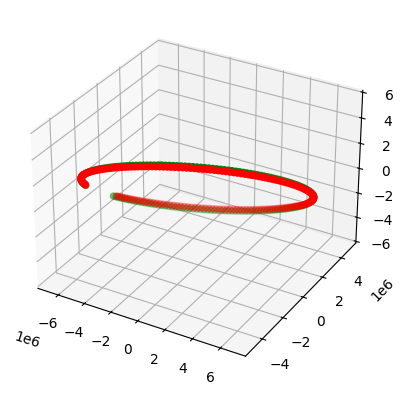

In [453]:
ax = plt.axes(projection='3d')
ax.scatter3D(xreal, yreal, zreal, color = 'green')
ax.scatter3D(x, y, z, color = 'red')